In [1]:
import numpy as np
import matplotlib.pyplot as plt
import client_moodle as server
import random
import copy
%matplotlib inline

In [2]:
# constants
TEAM_ID = 'dGtgGZhUiTAytVHtKMwFEbEBZl9vcBwrsP5rOSTTrLQuOsDAY2'

GENE_MIN = -10
GENE_MAX = 10

MUTATE_PROB = 0.2
MAX_MUTATE_DEC = 100 # Used for controlling the effect of noise, lesser it is more it effects the population

NUM_GENERATIONS = 10

In [3]:
# INITIAL_WEIGHTS = [ 0.00000000e+00,  1.00000000e+01, -4.80034174e+00,  4.36498598e-02,
#         2.74403982e-02,  6.32697901e-05, -4.31531895e-05, -8.66276945e-08,
#         2.50785838e-08,  2.67498675e-11, -4.84916657e-12] # 7.6L
INITIAL_WEIGHTS = [ 0.00000000e+00,  1.00000000e+01, -4.80024477e+00,  4.36429505e-02,
        2.74385273e-02,  6.32814025e-05, -4.31488730e-05, -8.66108225e-08,
        2.50746568e-08,  2.67605643e-11, -4.84830614e-12] # 7.6L
len(INITIAL_WEIGHTS)

11

In [4]:
class Darwin:
    '''
    This class encapsulates a genetic algorithm runner over population consisting of weight vectors
    '''
    CHROMOSOME_SIZE = 11
    POPULATION_SIZE = 8

    def __init__(self, val: list):
        if len(val) != self.CHROMOSOME_SIZE:
            raise ValueError

        self.population = self.generate_random_from_seed(val)
        self.population[0] = np.array(val)
        self.avg_fitness = [] # maintained across generations
        self.weight_fitness_map = [] # consists of tuples (vector,fitness)
        self.max_fitness_across_generations = None
        self.best_chromosome_across_generations = None
        self.train_for_best_chromosome = None
        self.valid_for_best_chromosome = None
        

    def generate_random_from_seed(self, val: list) -> np.ndarray:
        '''
        Generates a population from a single seed chromosome
        '''
        if len(val) != self.CHROMOSOME_SIZE:
            raise ValueError
        temp = [list(val) for i in range(self.POPULATION_SIZE)]
        temp = np.array(temp, dtype=np.double)
        temp =  self.mutate(temp)
        temp[0] = val
        return temp

    def get_fitness(self):
        
        def error_to_fitness(train_err, valid_err):
            return -(train_err + 1.6*valid_err)
        
        fitness = []
        train_errors = []
        valid_errors = []
        weight_fitness = []
        for chrom in self.population:
            train_err, valid_err = server.get_errors(TEAM_ID, list(chrom))
            fit = error_to_fitness(train_err, valid_err)
            fitness.append(fit)
            print(chrom)
            print(fit)
            train_errors.append(train_err)
            valid_errors.append(valid_err)
            weight_fitness.append((chrom,fit))

        fitness = np.array(fitness, dtype=np.double)
        self.weight_fitness_map = weight_fitness
        return fitness, train_errors, valid_errors

    @classmethod
    def crossover(self, mom: np.ndarray, dad: np.ndarray):
        '''
        Generates offsprings out of the two parents
        '''
            
        def random_prefix(mom: np.ndarray, dad: np.ndarray):
            '''
            Random prefixes and suffixes
            '''
            thresh = np.random.randint(self.CHROMOSOME_SIZE) # index
#             print("doing crossover between :-")
#             print(mom)
#             print(dad)
            alice = np.copy(dad)
            bob = np.copy(mom)
#             print("And the random point of cutting was "+str(thresh))
            alice[0:thresh] = mom[0:thresh]
            bob[0:thresh] = dad[0:thresh]
#             print("new children are :-")
#             print(alice)
#             print(bob)
            return alice,bob

        return random_prefix(mom, dad)

    @classmethod
    def mutate(self, population: np.ndarray):
        '''
        Mutates the population randomly
        '''
        temp_pop = copy.deepcopy(population)
        def add_gauss_noise(population: np.ndarray):
            means = np.mean(population, axis=0) # mean of each gene across the population - to keep mutations of level
            
            for idx, val in np.ndenumerate(population):
                if np.random.random() < MUTATE_PROB:
                    noise = np.random.normal(loc=means[idx[1]], scale=abs(means[idx[1]]/1000))
                    population[idx] += noise

            return np.clip(population, GENE_MIN, GENE_MAX)
        
        def add_uniform_noise(population: np.ndarray):
            for idx, val in np.ndenumerate(population):
                if np.random.random() < MUTATE_PROB:
                    range_lim = val/MAX_MUTATE_DEC
                    noise = np.random.uniform(low=-range_lim, high=range_lim)
                    population[idx] = population[idx] + noise
            return np.clip(population, GENE_MIN, GENE_MAX)
            
        temp = add_uniform_noise(population)
#         print("Changes due to mutation")
#         for i in range(self.POPULATION_SIZE):
#             for j in range(self.CHROMOSOME_SIZE):
#                 print(temp_pop[i][j],end="")
#                 print("->",end="")
#                 print(temp[i][j])
#             print("-----------------------------")
            
        return temp

    def breed(self):
        '''
        Creates the next generation
        '''
        def russian_roulette():
            def get_parent_index(thresholds):
                draw = np.random.random() # in [0, 1)

                for i in range(len(thresholds)):
                    if draw < thresholds[i]:
                        return i
                return len(thresholds) - 1    
            
            fitness, train_errors, valid_errors = self.get_fitness()
            normalized_fitness = (fitness - np.min(fitness)) / np.ptp(fitness) # in [0,1]
            
            self.avg_fitness.append(np.mean(fitness))
            self.update_best(fitness, train_errors, valid_errors)

            thresholds = []
            thresh = 0.0
            fitness_sum = np.sum(normalized_fitness)
            for val in normalized_fitness:
                thresh = thresh + (val/fitness_sum)
                thresholds.append(thresh)

            offsprings = []
            for i in range(int(self.POPULATION_SIZE/2)):
                mom = self.population[get_parent_index(thresholds)]
                dad = self.population[get_parent_index(thresholds)]

                alice, bob = self.crossover(mom, dad)
                offsprings.append(alice)
                offsprings.append(bob)
                
            return np.array(offsprings, dtype=np.double)
        
        def Sort_Tuple(tup):
            tup.sort(key = lambda x: x[1])  
            return tup  
        
        
        def normal_breed():
            fitness,train,valid = self.get_fitness()
            self.weight_fitness_map = Sort_Tuple(self.weight_fitness_map)
            self.weight_fitness_map.reverse()
            normalized_fitness = (fitness - np.min(fitness)) / np.ptp(fitness) # in [0,1]
            
            self.avg_fitness.append(np.mean(fitness))
            self.update_best(fitness,train,valid)
            
            offsprings = []
            for i in range(4):
                for j in range(i+1,4):
                    mom = self.weight_fitness_map[i][0]
                    dad = self.weight_fitness_map[j][0]
                    
                    alice, bob = self.crossover(mom,dad)
                    offsprings.append(alice)
            
            offsprings.append(self.weight_fitness_map[0][0])
            offsprings.append(self.weight_fitness_map[1][0])
            
            return np.array(offsprings, dtype=np.double)
        
        offsprings = russian_roulette()
        self.population = self.mutate(offsprings)
    
    def update_best(self, fitness: np.ndarray, train_errors: list, valid_errors: list):
        '''
        Updates the best chromosome across generations parameter from self.population
        '''
        best_idx = np.argmax(fitness)
        if (not self.max_fitness_across_generations) or fitness[best_idx] > self.max_fitness_across_generations:
            self.max_fitness_across_generations = fitness[best_idx]
            self.best_chromosome_across_generations = self.population[best_idx]
            self.train_for_best_chromosome = train_errors[best_idx]
            self.valid_for_best_chromosome = valid_errors[best_idx]

    def train(self):

        for i in range(NUM_GENERATIONS):
            self.breed()
        
        plt.plot(self.avg_fitness)
        plt.xlabel('Generations', fontsize=12)
        plt.ylabel('Average Fitness', fontsize=12)
        plt.title('Average Fitness across Generations', fontsize=14)
        plt.show()
        
        return self.best_chromosome_across_generations, self.max_fitness_across_generations, self.train_for_best_chromosome, self.valid_for_best_chromosome


In [5]:
darwin = Darwin(INITIAL_WEIGHTS)

In [6]:
best_chromosome, final_fitness, train_err, valid_err = darwin.train()

[ 0.00000000e+00  1.00000000e+01 -4.80024477e+00  4.36429505e-02
  2.74385273e-02  6.32814025e-05 -4.31488730e-05 -8.66108225e-08
  2.50746568e-08  2.67605643e-11 -4.84830614e-12]
-987032.8841595331
[ 0.00000000e+00  1.00000000e+01 -4.80024477e+00  4.36429505e-02
  2.74385273e-02  6.32814025e-05 -4.33845243e-05 -8.66108225e-08
  2.50746568e-08  2.67605643e-11 -4.84830614e-12]
-6051688.9206528785
[ 0.00000000e+00  1.00000000e+01 -4.81403411e+00  4.36429505e-02
  2.74385273e-02  6.29192291e-05 -4.31488730e-05 -8.66792850e-08
  2.50746568e-08  2.67605643e-11 -4.84830614e-12]
-981449.27243005
[ 0.00000000e+00  1.00000000e+01 -4.80024477e+00  4.36429505e-02
  2.76228730e-02  6.32814025e-05 -4.31488730e-05 -8.65222790e-08
  2.50790862e-08  2.67605643e-11 -4.84830614e-12]
-1678528.6784939053
[ 0.00000000e+00  1.00000000e+01 -4.80024477e+00  4.39846656e-02
  2.74385273e-02  6.32814025e-05 -4.35578002e-05 -8.66108225e-08
  2.50746568e-08  2.67605643e-11 -4.84830614e-12]
-15733108.966684824
[ 0.

NameError: name 'sys' is not defined

In [7]:
final_fitness

NameError: name 'final_fitness' is not defined

In [8]:
best_chromosome

NameError: name 'best_chromosome' is not defined

In [9]:
train_err

NameError: name 'train_err' is not defined

In [10]:
valid_err

NameError: name 'valid_err' is not defined

In [11]:
input()
# to prevent submissions on running all cells

''

In [12]:
status = server.submit(TEAM_ID, list(best_chromosome))
status

'successfully submitted'

In [12]:
darwin.max_fitness_across_generations


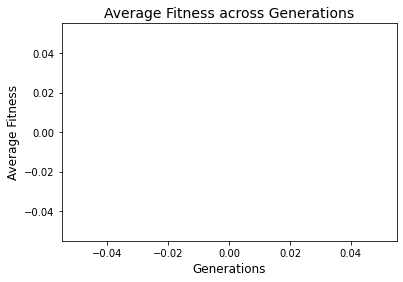

In [13]:
plt.plot(darwin.avg_fitness)
plt.xlabel('Generations', fontsize=12)
plt.ylabel('Average Fitness', fontsize=12)
plt.title('Average Fitness across Generations', fontsize=14)
plt.show()

In [14]:
vec = [-939161.1269820328,-915725.3356427758,-16865011.685222685,-58544095.1510417,-1659263.4978541355,-3265094.570422368,-7180432.299878756,-7223540.998257766]
vec = np.array(vec)
vec = vec - np.min(vec)
vec = vec/(np.ptp(vec))
print(vec)

[0.99959333 1.         0.72323898 0.         0.98709771 0.95923242
 0.89129127 0.89054322]
